## Data Science and Business Analytics Internship

## GRIP@The Spark Foundation 

## GRIPJAN'21

## Author - Harpragaas Singh

Task 7 :Stock Market Analysis 

Problem Statement : Create a hybrid model for stock perfomance prediction and sentimental analysis of news headlines.


In [1]:
# Importing relevant libraries
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

C:\Users\Harpragaas Singh\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Harpragaas Singh\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Apple Stock Analysis

In [57]:
# Getting the historical data
df = yf.download('AAPL',start='2001-01-01', 
                      end='2020-12-31', 
                      progress=False )
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229142,452312000
2001-01-03,0.258929,0.297991,0.257812,0.292411,0.252248,817073600
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.262839,739396000
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252248,412356000
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255137,373699200


In [62]:
df.reset_index(inplace =True)

In [63]:
df.rename(columns={'Date': 'date'}, inplace = True)

In [65]:
df.head()

,index,date,Open,High,Low,Close,Adj Close,Volume
0,0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229142,452312000
1,1,2001-01-03,0.258929,0.297991,0.257812,0.292411,0.252248,817073600
2,2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.262839,739396000
3,3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252248,412356000
4,4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255137,373699200


In [66]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

##### The dataset shows the stock price of apple from Jan 2001 till Dec 2020. The goal is to create a model that will forecast the closing price of the stock

#### 1. Visualizing per day closing price of the stock 

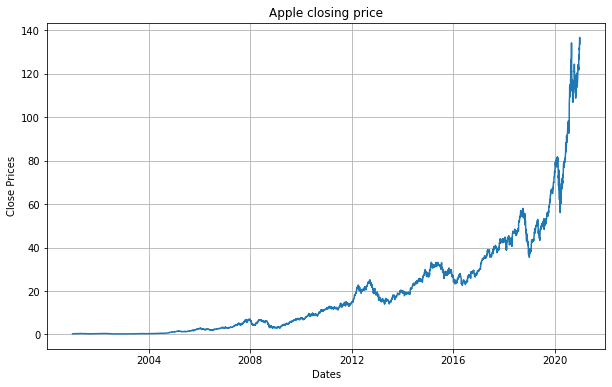

In [50]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Apple closing price')
plt.show()

<u>Scatter Plot of closing price</u>

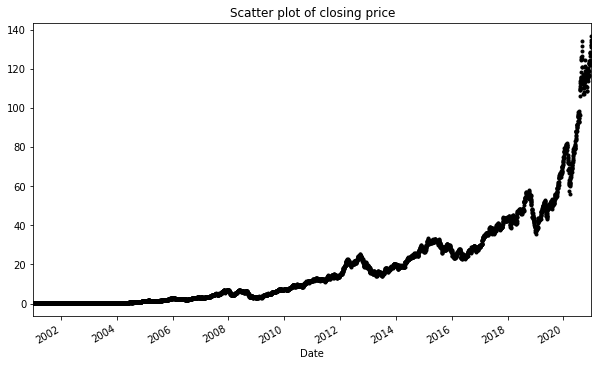

In [51]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

#### 2. Testing if the series is stationary or non-stationary

First we need to check if a series is stationary or not because time series analysis only works with stationary data.


<u>Testing for Stationary</u>


    1.H0, Null Hypothesis : It is non-stationary
    
    2.H1, Alternative Hypothesis : It is staionary
    
    
If both the mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

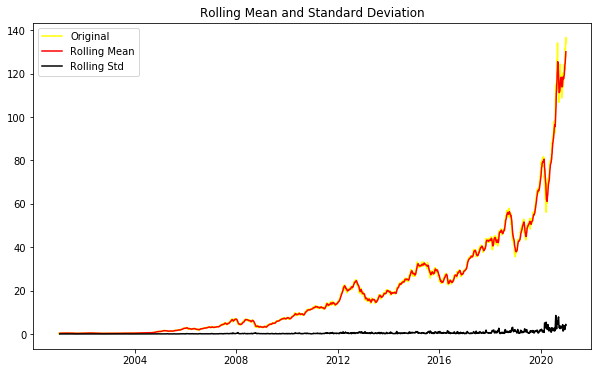

Results of dickey fuller test
Test Statistics                   4.546674
p-value                           1.000000
No. of lags used                 30.000000
Number of observations used    5000.000000
critical value (1%)              -3.431659
critical value (5%)              -2.862118
critical value (10%)             -2.567078
dtype: float64


In [52]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

###### After analysing the above graph, we can see increasing mean and standard deviation and hence the series is non-stationary. It is also observed that p value is greater than 0.05 so we cannot reject the <u>Null Hypothesis</u>. Also the test statistics is greater than the critical values.
###### Thus, the data is NON-STATIONARY

#### 3. Seperating Trend and Seasonality  

<Figure size 432x288 with 0 Axes>

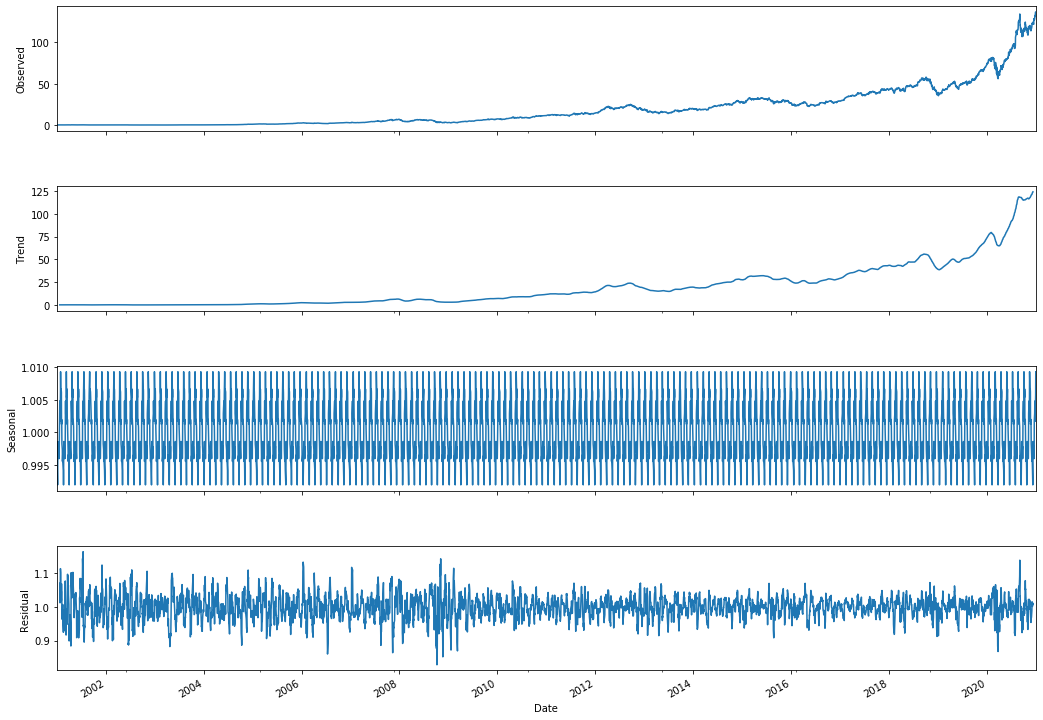

In [53]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 12)

###### From the graph, we can observe that trend and seasonality extracted from the series does seem reasonable. The residuals show similar trend throughout the years, with period of high variabilty post mid of 2018.

#### 4. ARIMA Model 

Creating the ARIMA model and training it with the closing price of the stock on the train data. 

So let us split the data into training and test set and visualize it.

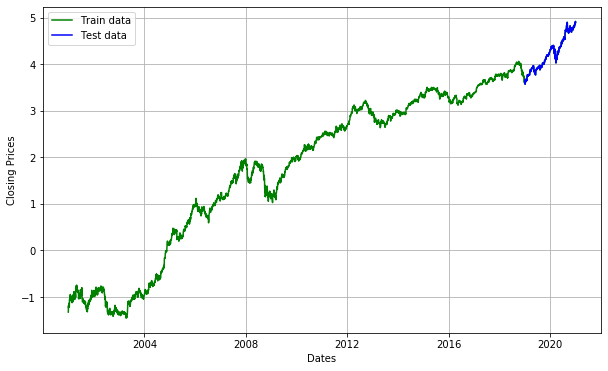

In [54]:
#Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.
df_log = np.log(df['Close'])
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [55]:
model_forecast = auto_arima(train_data, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-21150.764, BIC=-21118.691, Fit time=31.511 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-10282.513, BIC=-10269.684, Fit time=1.339 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=-19606.065, BIC=-19580.407, Fit time=22.235 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-14306.642, BIC=-14280.984, Fit time=14.480 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=-20638.218, BIC=-20599.731, Fit time=51.601 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=-18446.388, BIC=-18420.730, Fit time=2.812 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=-20878.663, BIC=-20840.176, Fit time=114.824 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=-21130.169, BIC=-21085.268, Fit time=90.663 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-21151.685, BIC=-21113.198, Fit time

In [32]:
model_forecast.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2488
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood                6648.848
Date:                            Sun, 17 Jan 2021   AIC                         -13287.695
Time:                                    13:31:57   BIC                         -13258.623
Sample:                                         0   HQIC                        -13277.136
                                           - 2488                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.391e-05   1.89e-05      2.318      0.020    6.78e-06    8.11e-05
ar.L1          0.9950      0.002    455.454      0.000       0.991       0.999
ar.S.L12       0.0067      0.020      0.333      0.739      -0.033       0.046
ma.S.L12      -0.9979      0.028    -35.143      0.000      -1.054      -0.942
sigma2         0.0003   8.22e-06     32.657      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       69.39   Jarque-Bera (JB):              2282.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

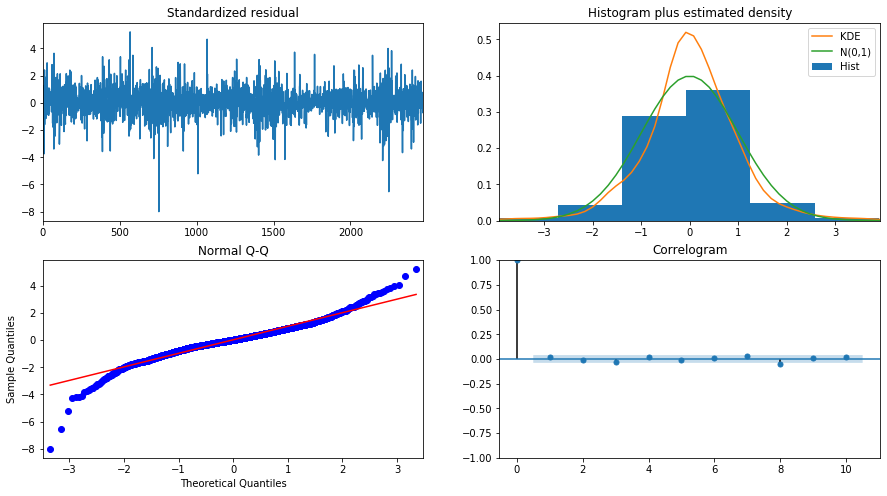

In [37]:
model_forecast.plot_diagnostics(figsize=(15,8))
plt.show()

#### 5. Forecast

In [51]:
# Using the best arima model for predicting the future stock price
prediction=model_forecast.predict(n_periods=277) #test_data size=277

In [42]:
#converting prediction array to a pandas data frame
prediction_dataframe=pd.DataFrame(prediction,columns=['Forecast'],index=test_data.index)

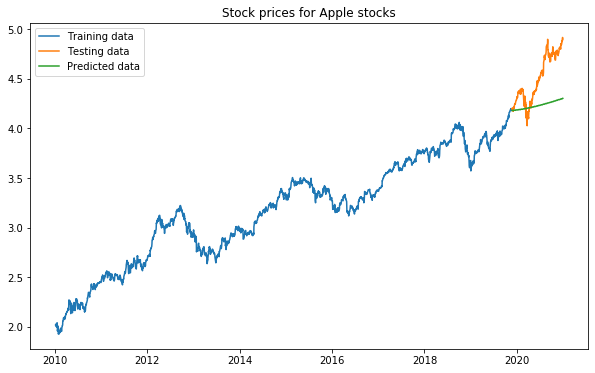

In [50]:
#now let us plot the training,testing and prediction values over the graph
plt.figure(figsize=(10,6))
plt.plot(train_data,label='Training data')
plt.plot(test_data,label='Testing data')
plt.plot(prediction_dataframe,label='Predicted data')
plt.legend()
plt.title("Stock prices for Apple stocks")
plt.show()

##### The above graph shows the future trend of apple stock.

#### 6. Model Accuracy

In [54]:
from sklearn import metrics  
from sklearn.metrics import mean_squared_error
print('Root Mean Square Error:',np.sqrt(metrics.mean_squared_error(test_data, prediction)))

Root Mean Square Error: 0.3395072139497109


##### The RMSE value of 0.34 shows that the model can predict the data accurately

### Headlines Sentiment Analysis

In [3]:
#Importing relevant libraries
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import re
import seaborn as sns

[nltk_data] Downloading package punkt to C:\Users\Harpragaas
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Harpragaas Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to C:\Users\Harpragaas
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Harpragaas
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
#Loading the dataset
news = pd.read_csv("india-news-headlines.csv")
news.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [6]:
# Formating publish_date 
news['publish_date']=pd.to_datetime(news['publish_date'],format = '%Y%m%d')
news.head()

,publish_date,headline_category,headline_text
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...
1,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,For bigwigs; it is destination Goa


In [8]:
#Understanding the dataset
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
publish_date         datetime64[ns]
headline_category    object
headline_text        object
dtypes: datetime64[ns](1), object(2)
memory usage: 75.5+ MB


In [12]:
#Checking for columns which are empty
news.isna().sum()/len(news)

publish_date         0.0
headline_category    0.0
headline_text        0.0
dtype: float64

There are no missing values.

In [20]:
# Sorting the dataset to delete the duplicates
cols = list(news.columns)
news.sort_values(by=cols, inplace=True)

In [76]:
news[news.duplicated(keep=False)].head()

,publish_date,headline_category,headline_text


In [23]:
news.drop_duplicates(keep='last', inplace=True)

In [25]:
news.duplicated().sum()

0

##### We have deleted all duplicate values

#### 1. Performing Sentiment Analysis

In [26]:
#Identifying a list of unique dates
l1 = news['publish_date'].value_counts().index.tolist()

In [27]:
#Concatenating all the headlines of the same date
new=[]
for x in l1:
  df = news.loc[news['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

In [28]:
# Creating new dataset
newsdf = pd.DataFrame({'publish_date': l1, 'headline_text' : new})

In [29]:
newsdf.sort_values(by='publish_date',inplace = True)

In [31]:
newsdf.head()

,publish_date,headline_text
7079,2001-01-01,win over cena satisfying but defeating underta...
6938,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
6974,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
6796,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
6948,2001-01-05,Nepal won't allow anti-India activities: Envoy...


##### Sentiment Analysis is performed using TextBlob. Based on the polarity, we can determine whether it is a positive, negative or neutral text.
##### Polarity :


1. if polarity > 0 : positive

2. if polarity = 0 : neutral

3. if polarity < 0 : negative 


##### Subjectivity :  amount of personal opion and factual information in the text. Higher the subjectivity, higher is the personal opinon in the text.

In [32]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
  polarity.append(TextBlob(row['headline_text']).sentiment[0])
  subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [33]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

In [36]:
newsdf.head(15)

,publish_date,headline_text,polarity,subjectivity
7079,2001-01-01,win over cena satisfying but defeating underta...,0.433333,0.633333
6938,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
6974,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
6796,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
6948,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
7051,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935
6963,2001-01-07,Aamir Khan: 'Lagaan' ko zabaan do. Are green a...,-0.029809,0.369236
6980,2001-01-08,42 units to be sealed in phase-II of operation...,0.016234,0.436176
6954,2001-01-09,50 handicaps to get artificial limbs. ABVP org...,0.020856,0.486272
7056,2001-01-10,Bureaucracy undermining legislature's 'existen...,0.000000,0.000000


In [35]:
#Checking for null values 
newsdf.isna().sum()/len(newsdf)

publish_date     0.0
headline_text    0.0
polarity         0.0
subjectivity     0.0
dtype: float64

There are no missing value

In [67]:
#Renaming the dataset
newsdf.rename(columns={'publish_date': 'date'}, inplace = True)

In [68]:
newsdf = newsdf.filter(['date', 'polarity', 'subjectivity'], axis=1)

In [69]:
#Merging the two datasets
apple = pd.merge(df,newsdf, how='left', on=['date'])

In [71]:
apple.head()

,index,date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229142,452312000,0.193519,0.293056
1,1,2001-01-03,0.258929,0.297991,0.257812,0.292411,0.252248,817073600,0.088462,0.407692
2,2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.262839,739396000,0.091426,0.481895
3,3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252248,412356000,0.257415,0.465542
4,4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255137,373699200,0.016234,0.436176


#### 2. Predicting Apple Stock 

###### We predict the Apple Stock using the ARIMA model on 'apple' as we performed on the 'df' dataset above and compare both the graphs to see how sentiment analysis effect the prediction of stock.

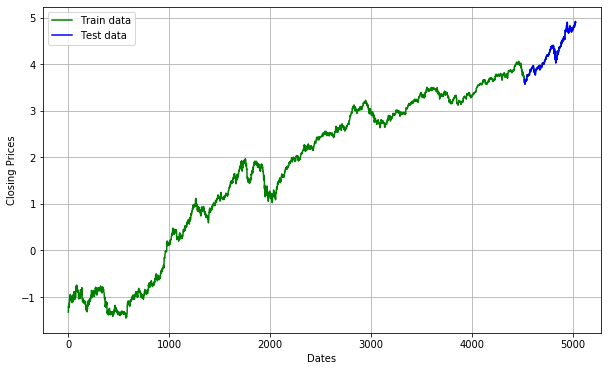

In [87]:
#Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.
df_log1 = np.log(apple['Close'])
train_data1, test_data1 = df_log1[3:int(len(df_log1)*0.9)], df_log1[int(len(df_log1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log1, 'green', label='Train data')
plt.plot(test_data1, 'blue', label='Test data')
plt.legend()

In [75]:
model_forecast1 = auto_arima(train_data1, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-21150.764, BIC=-21118.691, Fit time=28.984 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-10282.513, BIC=-10269.684, Fit time=1.749 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=-19606.065, BIC=-19580.407, Fit time=22.963 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-14306.642, BIC=-14280.984, Fit time=15.755 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=-20638.218, BIC=-20599.731, Fit time=52.184 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=-18446.388, BIC=-18420.730, Fit time=3.448 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=-20878.663, BIC=-20840.176, Fit time=125.278 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=-21130.169, BIC=-21085.268, Fit time=92.275 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-21151.685, BIC=-21113.198, Fit time

In [77]:
model_forecast1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4524
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 12)   Log Likelihood               10581.659
Date:                            Tue, 19 Jan 2021   AIC                         -21155.319
Time:                                    14:14:13   BIC                         -21129.661
Sample:                                         0   HQIC                        -21146.279
                                           - 4524                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.433e-05    1.5e-05      1.624      0.104   -5.03e-06    5.37e-05
ar.L1          0.9981      0.001   1019.027      0.000       0.996       1.000
ma.S.L12      -0.9913      0.004   -241.098      0.000      -0.999      -0.983
sigma2         0.0005   5.88e-06     89.219      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       59.96   Jarque-Bera (JB):              5411.37
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

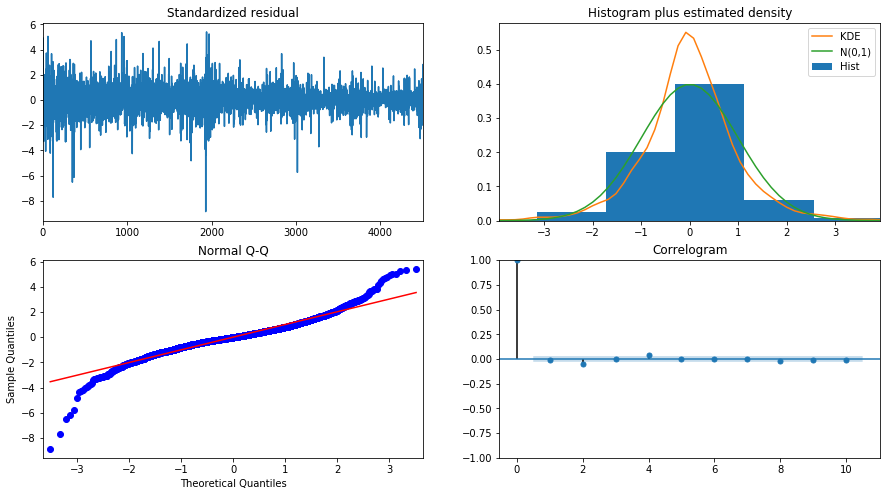

In [78]:
model_forecast1.plot_diagnostics(figsize=(15,8))
plt.show()

In [81]:
# Using the best arima model for predicting the future stock price
prediction1=model_forecast1.predict(n_periods=504) #test_data size=277

In [82]:
#converting prediction array to a pandas data frame
prediction_dataframe1=pd.DataFrame(prediction1,columns=['Forecast'],index=test_data1.index)

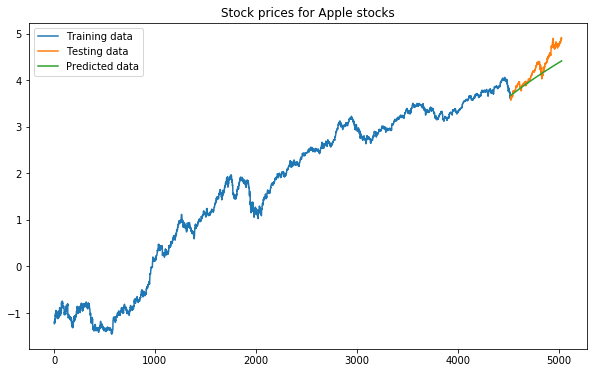

In [89]:
#now let us plot the training,testing and prediction values over the graph
plt.figure(figsize=(10,6))
plt.plot(train_data1,label='Training data')
plt.plot(test_data1,label='Testing data')
plt.plot(prediction_dataframe1,label='Predicted data')
plt.legend()
plt.title("Stock prices for Apple stocks")
plt.show()

In [86]:
from sklearn import metrics  
from sklearn.metrics import mean_squared_error
print('Root Mean Square Error:',np.sqrt(metrics.mean_squared_error(test_data, prediction1)))

Root Mean Square Error: 0.23797123958663932


##### We can see that both the models predict the similar trend for closing prices of the stock, indeed the hybrid model perform better in terms of accuracy with RMSE value of 0.23 in contrast with the value of 0.34 of the previous model. 